In [1]:
import os
import cv2
import numpy as np
import trimesh
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.utils import save_image, make_grid
from models.networks.smpl import SMPL
from models.networks.render import SMPLRenderer
from utils.multi_garment_dataset import Multi_Garment_Dataset
from utils.util import load_obj, load_pickle_file, write_pickle_file, get_f2vts, get_f2vts_from_obj

In [2]:
data_root = 'data/Multi-Garment_dataset'
vis_result_dir = 'outputs/vis_result'
pose_cam_path = 'assets/pose_cam.pkl'
batch_size = 16
tex_size = 3
image_size = 256
uv_size = 256
isHres = False

In [3]:
smpl = SMPL(pkl_path='assets/smpl_model.pkl', isHres=isHres).cuda()
if isHres:
    faces = smpl.faces_hres
else:
    faces = smpl.faces
smpl_render = SMPLRenderer(faces=faces).cuda()

In [4]:
smpl_render.set_bg_color((1, 1, 1))
#smpl_render.set_ambient_light(int_dir=0.3, int_amb=0.7, direction=(1, 0.5, 0.5))

In [5]:
train_dataset = Multi_Garment_Dataset(data_root=data_root, pose_cam_path=pose_cam_path, isHres=isHres)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [6]:
for i, data in enumerate(train_loader):
    shape = data['shape'].cuda()
    pose = data['pose'].cuda()
    cam = data['cam'].cuda()
    v_personal = data['v_personal'].cuda()
    uv_image = data['uv_image'].cuda()
    f2vts = data['f2vts'].cuda()
    
    tex = smpl_render.extract_tex(uv_image, smpl_render.points_to_sampler(f2vts))
    
    print('shape: ', shape.size())
    print('pose: ', pose.size())
    print('cam: ', cam.size())
    print('v_personal: ', v_personal.size())
    print('uv_image: ', uv_image.size())
    print('f2vts: ', f2vts.size())
    print('tex: ', tex.size())
    
    if i >= 0:
        break

shape:  torch.Size([16, 10])
pose:  torch.Size([16, 72])
cam:  torch.Size([16, 3])
v_personal:  torch.Size([16, 6890, 3])
uv_image:  torch.Size([16, 3, 2048, 2048])
f2vts:  torch.Size([16, 13776, 3, 2])
tex:  torch.Size([16, 13776, 3, 3, 3, 3])


In [7]:
verts = smpl(shape, pose, v_personal)
verts = smpl_render.project_to_image(verts, cam, flip=False, withz=True)
img_masked = smpl_render.render(verts, tex)
print(img_masked.size())

torch.Size([16, 3, 256, 256])


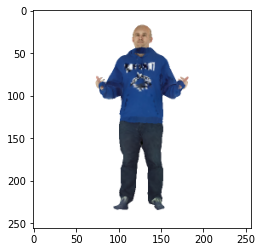

In [8]:
img_vis = (img_masked.detach().cpu().numpy()[0] * 255).astype(np.uint8).transpose(1, 2, 0)
plt.imshow(img_vis)

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UVImageModel(nn.Module):
    def __init__(self, uv, image_size):
        super(UVImageModel, self).__init__()
        # (1, 3, image_size, image_size)
        self.weight = nn.Parameter(torch.zeros(1, 3, image_size, image_size) - 1.0)
         # (f, t, t, 2)
        self.f, self.t = uv.shape[:2]
        # (1, f, t*t, 2)
        uv = uv.reshape(1, self.f, self.t * self.t, 2)
        self.uv = uv
    
    def forward(self):
        uv_image = torch.tanh(self.weight)
        texture = F.grid_sample(uv_image, self.uv)
        # (1,3,f,t,t)
        texture = texture.view(1, 3, self.f, self.t, self.t)
        # (1,f,t,t,3)
        texture = texture.permute(0, 2, 3, 4, 1)

        return texture

    def get_uv_image(self):
        return torch.tanh(self.weight).detach()

In [10]:
if isHres:
    vt, ft = load_pickle_file('assets/smpl_vt_ft_hres.pkl')
else:
    vt, ft = load_pickle_file('assets/smpl_vt_ft.pkl')
f2vts = torch.from_numpy(get_f2vts(vt, ft)).float().cuda()
print(f2vts.size())

torch.Size([13776, 3, 2])


In [11]:
# f2vts = torch.from_numpy(get_f2vts_from_obj('assets/uv_mapper.txt')).float().cuda()
# print(f2vts.size())

In [12]:
uv = smpl_render.points_to_sampler(f2vts[None])[0]
uv = uv.view(uv.shape[0], tex_size, tex_size, 2)
uv = uv * 2 - 1
print(uv.size())

torch.Size([13776, 3, 3, 2])


In [13]:
pose_cam_pkl = load_pickle_file(pose_cam_path)
poses = torch.from_numpy(pose_cam_pkl['poses']).float().cuda()
cams = torch.from_numpy(pose_cam_pkl['cams']).float().cuda()
print(poses.size())
print(cams.size())

torch.Size([961, 72])
torch.Size([961, 3])


In [14]:
def compute_uv_image(shape_src, v_personal_src, tex_src):
    uv_image_model = UVImageModel(uv, image_size=uv_size).cuda()
    opt = torch.optim.Adam(uv_image_model.parameters(), lr=1e-2)
    criterion = nn.MSELoss()
    scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=1, gamma=0.5)
    for epoch in range(1):
        print('Epoch: {} lr = {}'.format(epoch, opt.param_groups[0]['lr']))
        for i in range(poses.size(0)):
            pose_ref = poses[i][None]
            cam_ref = cams[i][None]
            verts_ref = smpl(shape_src, pose_ref, v_personal_src)
            verts_ref = smpl_render.project_to_image(verts_ref, cam_ref, flip=True, withz=True)
            img_ref = smpl_render.render(verts_ref, tex_src)
            fim_ref = smpl_render.render_fim(verts_ref)
            tex_ref = smpl_render.extract_tex_from_image(img_ref, verts_ref, repeat=False)
            vis_face_ids = fim_ref.unique()[1:].long()

            for _ in range(1):
                pred_tex = uv_image_model()
                loss = criterion(pred_tex[:, vis_face_ids], tex_ref[:, vis_face_ids])
                loss.backward()
                opt.step()
                opt.zero_grad()

            if i % 100 == 0:
                print('{}/{} loss = {}'.format(i, poses.size(0), loss.item()))
        scheduler.step()
    return uv_image_model.get_uv_image()

In [15]:
for i in range(batch_size):
    save_image(img_masked[i].cpu(), os.path.join(vis_result_dir, 'img_{}.jpg'.format(i)))
    uv_image = compute_uv_image(shape[i][None], v_personal[i][None], tex[i][None])
    save_image(uv_image[0].cpu(), os.path.join(vis_result_dir, 'uv_img_{}.jpg'.format(i)))

Epoch: 0 lr = 0.01
0/961 loss = 1.252338171005249
100/961 loss = 0.3145768940448761
200/961 loss = 0.07003523409366608
300/961 loss = 0.05443562567234039
400/961 loss = 0.01258531492203474
500/961 loss = 0.009619617834687233
600/961 loss = 0.00846315361559391
700/961 loss = 0.0045697432942688465
800/961 loss = 0.006916288286447525
900/961 loss = 0.008924058638513088
Epoch: 0 lr = 0.01
0/961 loss = 1.0834321975708008
100/961 loss = 0.22619527578353882
200/961 loss = 0.05352216213941574
300/961 loss = 0.03467446193099022
400/961 loss = 0.009102832525968552
500/961 loss = 0.009204593487083912
600/961 loss = 0.009951149113476276
700/961 loss = 0.004245555028319359
800/961 loss = 0.009071587584912777
900/961 loss = 0.009823360480368137
Epoch: 0 lr = 0.01
0/961 loss = 1.5373785495758057
100/961 loss = 0.4093421697616577
200/961 loss = 0.09899955242872238
300/961 loss = 0.07313027232885361
400/961 loss = 0.01390577107667923
500/961 loss = 0.008519948460161686
600/961 loss = 0.0074417027644813

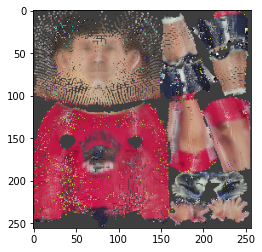

In [16]:
uv_image_vis = (uv_image.cpu().numpy()[0]* 255).astype(np.uint8).transpose(1, 2, 0)
plt.imshow(uv_image_vis)